# 앙상블 주식 채권 비중별

- 투자 자산 : 주식(코스피200, SPY), 채권(20년 만기 국고채, TLT)
- 투자비율 : 다음과 같은 11개의 포트폴리오(투자 전략)를 만든다(매월 말 해당 비중대로 리밸런싱).
- 매월 말 11개 전략의 수익곡선 확인
  - 주식 100%~0% 채권 0~100%
- 각 수익곡선의 최근 '6개월 모멘텀(수익률) / 최근 6개월 수익률 변동성' 상위 n 개 포트폴리오를 선정
- 동일비중으로 투자
- 결과
  - 한국 그림 2-39
      - 코스피 10.0%/-47..0%
      - 20년 만기 국고채 13.0%/-20.7%
      - 전략 15.7%/-14.5%
  - 미국 그림 2-40
      - SPY 9.7%/-50.8%
      - TLT 6.3%/-21.8%
      - 전략 10.7%/-17.5%

In [1]:
from settings import *

In [2]:
tickers = ['SPY', 'TLT']
data = yf.download(tickers)['Adj Close']
data = data.dropna()
data.info()

[*********************100%***********************]  2 of 2 completed
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4924 entries, 2002-07-30 to 2022-02-16
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SPY     4924 non-null   float64
 1   TLT     4924 non-null   float64
dtypes: float64(2)
memory usage: 115.4 KB


In [3]:
data['2002-7']

,SPY,TLT
Date,,
2002-07-30,62.377,42.148
2002-07-31,62.528,42.671


In [4]:
s = '2002-7-31'
e = '2017-6-30'
start = '2003-2-28'

In [5]:
data = data[s:]

In [6]:
data

,SPY,TLT
Date,,
2002-07-31,62.528,42.671
2002-08-01,60.895,42.914
2002-08-02,59.530,43.353
2002-08-05,57.459,43.544
2002-08-06,59.393,43.172
...,...,...
2022-02-10,449.320,136.230
2022-02-11,440.460,138.250
2022-02-14,439.020,136.530


In [7]:
def strategy(name, data, index, bond):
    s = bt.Strategy(name,
            [
                bt.algos.RunMonthly(run_on_end_of_period=True),
                bt.algos.SelectAll(),
                bt.algos.WeighSpecified(SPY=index, TLT=bond),
                # PrintTempWeights(),
                bt.algos.Rebalance(),
            ])

    return bt.Backtest(s, data, initial_capital=100000000.0)

In [8]:
t1 = strategy("t1",   data, 1.0, 0.0)
t2 = strategy("t2",   data, 0.9, 0.1)
t3 = strategy("t3",   data, 0.8, 0.2)
t4 = strategy("t4",   data, 0.7, 0.3)
t5 = strategy("t5",   data, 0.6, 0.4)
t6 = strategy("t6",   data, 0.5, 0.5)
t7 = strategy("t7",   data, 0.4, 0.6)
t8 = strategy("t8",   data, 0.3, 0.7)
t9 = strategy("t9",   data, 0.2, 0.8)
t10 = strategy("t10", data, 0.1, 0.9)
t11 = strategy("t11", data, 0.0, 1.0)

In [9]:
r_all = bt.run(t1,t2,t3,t4,t5,t6,t7,t8,t9,t10,t11)

In [10]:
r_all.display()

Stat                 t1          t2          t3          t4          t5          t6          t7          t8          t9          t10         t11
-------------------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------
Start                2002-07-30  2002-07-30  2002-07-30  2002-07-30  2002-07-30  2002-07-30  2002-07-30  2002-07-30  2002-07-30  2002-07-30  2002-07-30
End                  2022-02-16  2022-02-16  2022-02-16  2022-02-16  2022-02-16  2022-02-16  2022-02-16  2022-02-16  2022-02-16  2022-02-16  2022-02-16
Risk-free rate       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%

Total Return         614.24%     587.65%     555.61%     519.07%     478.99%     436.40%     392.29%     347.59%     303.19%     259.84%     218.21%
Daily Sharpe         0.62        0.68        0.75        0.84        0.93        0.99        0.99     

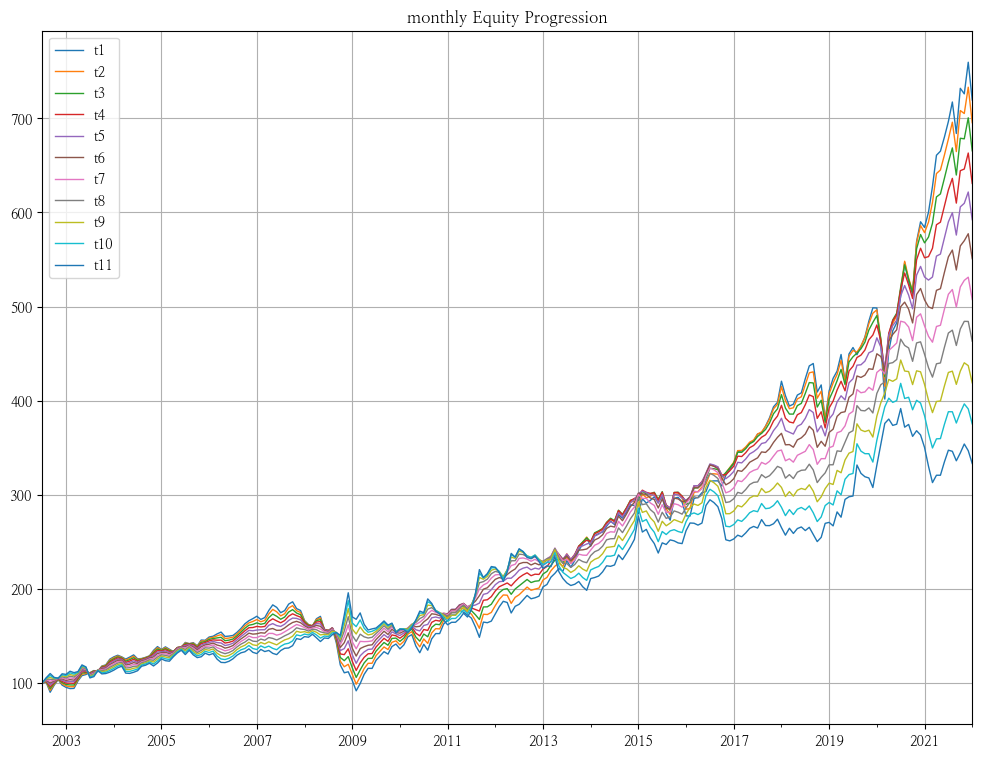

In [11]:
r_all.plot(freq='M', figsize=(12, 9));

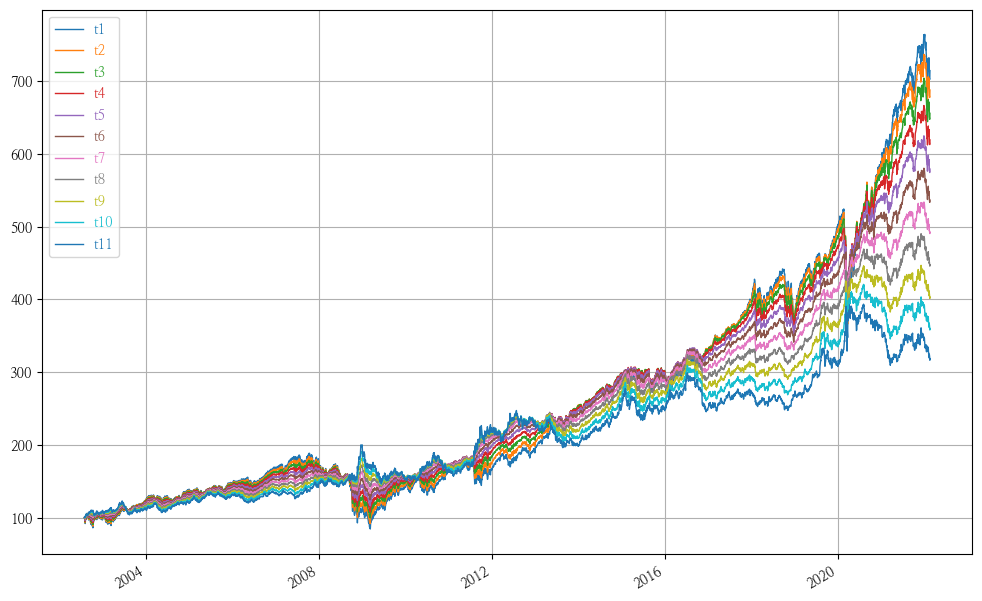

In [12]:
plot_df(r_all.prices, figsize=(12,9), logy=False)

In [13]:
class StatCalcRiskAdjustedReturn(bt.Algo):
    def __init__(self, lookback=6):
        super(StatCalcRiskAdjustedReturn, self).__init__()
        self.lookback = lookback

    def __call__(self, target):
        selected = target.temp['selected']

        prev_month = target.now# - pd.DateOffset(months=1)
        t0 = prev_month.strftime("%Y-%m")
        start = (prev_month - pd.DateOffset(months=self.lookback)).strftime("%Y-%m")

        prc = target.universe.loc[start:t0, selected].resample('M').last()

        월별수익률 = prc.pct_change().dropna()
        변동성 = 월별수익률.std()

        모멘텀 = prc.calc_total_return()
        stats = 모멘텀/변동성
        # print(f"=== {t0} {start} \n{prc}\n==월별수익률\n{월별수익률} \n==returns\n{모멘텀} \n==std\n{변동성}\nstats==\n{stats}\n")

        target.temp['stat'] = pd.Series(stats, index=prc.columns)

        return True

In [14]:
r_all.prices

,t1,t2,t3,t4,t5,t6,t7,t8,t9,t10,t11
2002-07-30,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000
2002-07-31,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000
2002-08-01,97.389,97.707,98.025,98.343,98.661,98.979,99.297,99.615,99.933,100.251,100.569
2002-08-02,95.206,95.846,96.485,97.124,97.764,98.403,99.042,99.681,100.321,100.960,101.599
2002-08-05,91.893,92.909,93.924,94.940,95.955,96.971,97.986,99.001,100.017,101.032,102.048
...,...,...,...,...,...,...,...,...,...,...,...
2022-02-10,718.594,691.649,659.253,622.337,581.893,538.940,494.477,449.458,404.753,361.135,319.260
2022-02-11,704.424,680.312,650.659,616.329,578.260,537.428,494.806,451.327,407.864,365.195,323.994
2022-02-14,702.121,677.468,647.345,612.626,574.257,533.215,490.472,446.960,403.542,360.989,319.963
2022-02-15,713.444,686.559,654.273,617.512,577.267,534.547,490.348,445.612,401.207,357.897,316.330


In [15]:
s

'2002-7-31'

In [16]:
data1  = r_all.prices[s:]
data1.head()

,t1,t2,t3,t4,t5,t6,t7,t8,t9,t10,t11
2002-07-31,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000,100.000
2002-08-01,97.389,97.707,98.025,98.343,98.661,98.979,99.297,99.615,99.933,100.251,100.569
2002-08-02,95.206,95.846,96.485,97.124,97.764,98.403,99.042,99.681,100.321,100.960,101.599
2002-08-05,91.893,92.909,93.924,94.940,95.955,96.971,97.986,99.001,100.017,101.032,102.048
2002-08-06,94.987,95.606,96.225,96.843,97.462,98.081,98.700,99.319,99.938,100.556,101.175


In [17]:
after_date = (datetime.strptime(start, '%Y-%m-%d') - pd.DateOffset(days=1)).strftime('%Y-%m-%d')
after_date

'2003-02-27'

In [18]:
st = bt.Strategy("ensemble",
        [
            bt.algos.RunMonthly(run_on_end_of_period=True), #월초
            bt.algos.RunAfterDate(after_date),
            bt.algos.SelectAll(),
            #-------------------------------------------
            StatCalcRiskAdjustedReturn(lookback=6),
            bt.algos.SelectN(3),
            bt.algos.WeighEqually(),
            #-------------------------------------------
            PrintTempWeights(),
            bt.algos.Rebalance()
        ]
)

In [19]:
bt_ensemble = bt.Backtest(st, data1, initial_capital=100000000.0)
r = bt.run(bt_ensemble)

2003-02-28 00:00:00 ensemble t9:0.333 t8:0.333 t10:0.333 
2003-03-31 00:00:00 ensemble t7:0.333 t6:0.333 t8:0.333 
2003-04-30 00:00:00 ensemble t9:0.333 t8:0.333 t10:0.333 
2003-05-30 00:00:00 ensemble t10:0.333 t11:0.333 t9:0.333 
2003-06-30 00:00:00 ensemble t5:0.333 t6:0.333 t4:0.333 
2003-07-31 00:00:00 ensemble t1:0.333 t2:0.333 t3:0.333 
2003-08-29 00:00:00 ensemble t1:0.333 t2:0.333 t3:0.333 
2003-09-30 00:00:00 ensemble t1:0.333 t2:0.333 t3:0.333 
2003-10-31 00:00:00 ensemble t1:0.333 t2:0.333 t3:0.333 
2003-11-28 00:00:00 ensemble t2:0.333 t1:0.333 t3:0.333 
2003-12-31 00:00:00 ensemble t2:0.333 t1:0.333 t3:0.333 
2004-01-30 00:00:00 ensemble t5:0.333 t6:0.333 t4:0.333 
2004-02-27 00:00:00 ensemble t5:0.333 t6:0.333 t4:0.333 
2004-03-31 00:00:00 ensemble t6:0.333 t5:0.333 t7:0.333 
2004-04-30 00:00:00 ensemble t1:0.333 t2:0.333 t3:0.333 
2004-05-28 00:00:00 ensemble t1:0.333 t2:0.333 t3:0.333 
2004-06-30 00:00:00 ensemble t1:0.333 t2:0.333 t3:0.333 
2004-07-30 00:00:00 ensembl

In [20]:
r.set_date_range(start,e)
r.display()

Stat                 ensemble
-------------------  ----------
Start                2003-02-28
End                  2017-06-30
Risk-free rate       0.00%

Total Return         365.81%
Daily Sharpe         1.05
Daily Sortino        1.75
CAGR                 11.33%
Max Drawdown         -22.46%
Calmar Ratio         0.50

MTD                  0.65%
3m                   3.01%
6m                   8.87%
YTD                  8.87%
1Y                   13.13%
3Y (ann.)            11.76%
5Y (ann.)            13.82%
10Y (ann.)           11.69%
Since Incep. (ann.)  11.33%

Daily Sharpe         1.05
Daily Sortino        1.75
Daily Mean (ann.)    11.32%
Daily Vol (ann.)     10.73%
Daily Skew           -0.11
Daily Kurt           3.57
Best Day             4.16%
Worst Day            -4.29%

Monthly Sharpe       1.07
Monthly Sortino      2.19
Monthly Mean (ann.)  11.33%
Monthly Vol (ann.)   10.56%
Monthly Skew         0.27
Monthly Kurt         3.99
Best Month           12.39%
Worst Month          -12.58

In [21]:
r.prices.resample('M').last().to_drawdown_series().min()

ensemble   -0.179
dtype: float64

<AxesSubplot:>

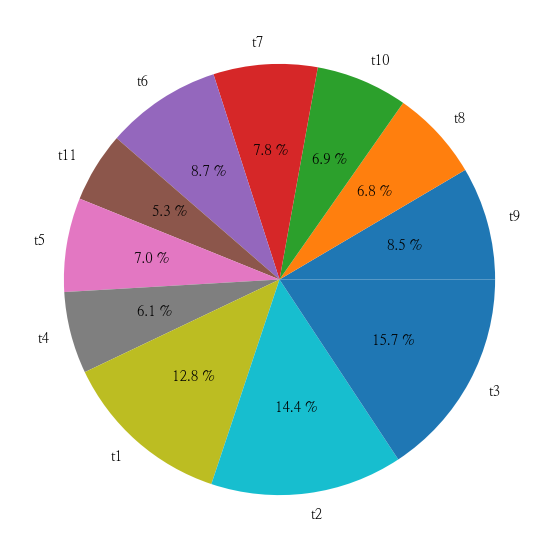

In [22]:
r.get_security_weights().sum(axis=0).plot.pie(autopct='%.1f %%', ylabel='', figsize=(7,7))

In [23]:
bt_spy = long_only_ew(data, ['SPY'], 'SPY')
bt_tlt = long_only_ew(data, ['TLT'], 'TLT')

r_spy = bt.run(bt_spy)
r_tlt  = bt.run(bt_tlt)

2002-07-31 00:00:00
2002-07-31 00:00:00


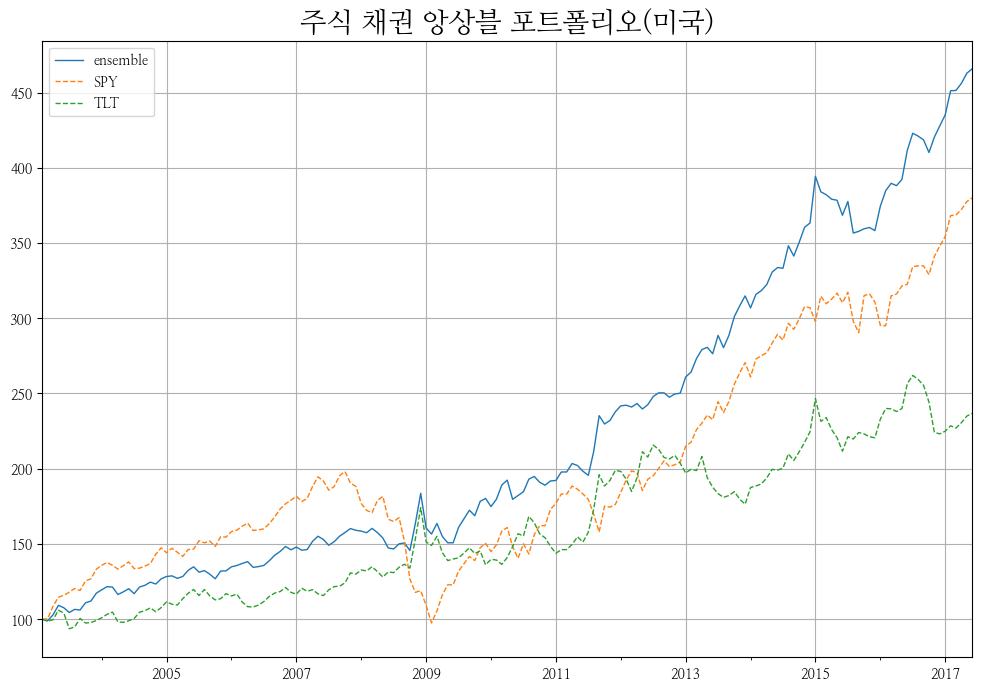

In [24]:
r_spy.set_date_range(start,e)
r_tlt.set_date_range(start,e)

ax1 = r.plot(freq='M', figsize=(12,8));
r_spy.plot(ax=ax1, freq='M', ls='--', figsize=(12,8));
r_tlt.plot(ax=ax1, freq='M', ls='--', figsize=(12,8))
plt.title("주식 채권 앙상블 포트폴리오(미국)", fontsize=20);

In [25]:
r_asset = bt.run(bt_spy, bt_tlt, bt_ensemble)
r_asset.set_date_range(start, e)
r_asset.display()

Stat                 SPY         TLT         ensemble
-------------------  ----------  ----------  ----------
Start                2003-02-28  2003-02-28  2003-02-28
End                  2017-06-30  2017-06-30  2017-06-30
Risk-free rate       0.00%       0.00%       0.00%

Total Return         279.96%     136.82%     365.81%
Daily Sharpe         0.60        0.51        1.05
Daily Sortino        0.94        0.85        1.75
CAGR                 9.76%       6.20%       11.33%
Max Drawdown         -55.19%     -26.59%     -22.46%
Calmar Ratio         0.18        0.23        0.50

MTD                  0.64%       0.79%       0.65%
3m                   2.83%       4.61%       3.01%
6m                   9.17%       6.13%       8.87%
YTD                  9.17%       6.13%       8.87%
1Y                   17.77%      -7.71%      13.13%
3Y (ann.)            9.51%       5.95%       11.76%
5Y (ann.)            14.46%      2.44%       13.82%
10Y (ann.)           6.98%       7.37%       11.69%
Since

In [26]:
r_asset.prices.resample('M').last().to_drawdown_series().min()

SPY        -0.508
TLT        -0.218
ensemble   -0.179
dtype: float64

           CAGR
SPY       9.759
TLT       6.199
ensemble 11.330
             MDD
SPY      -55.189
TLT      -26.585
ensemble -22.460


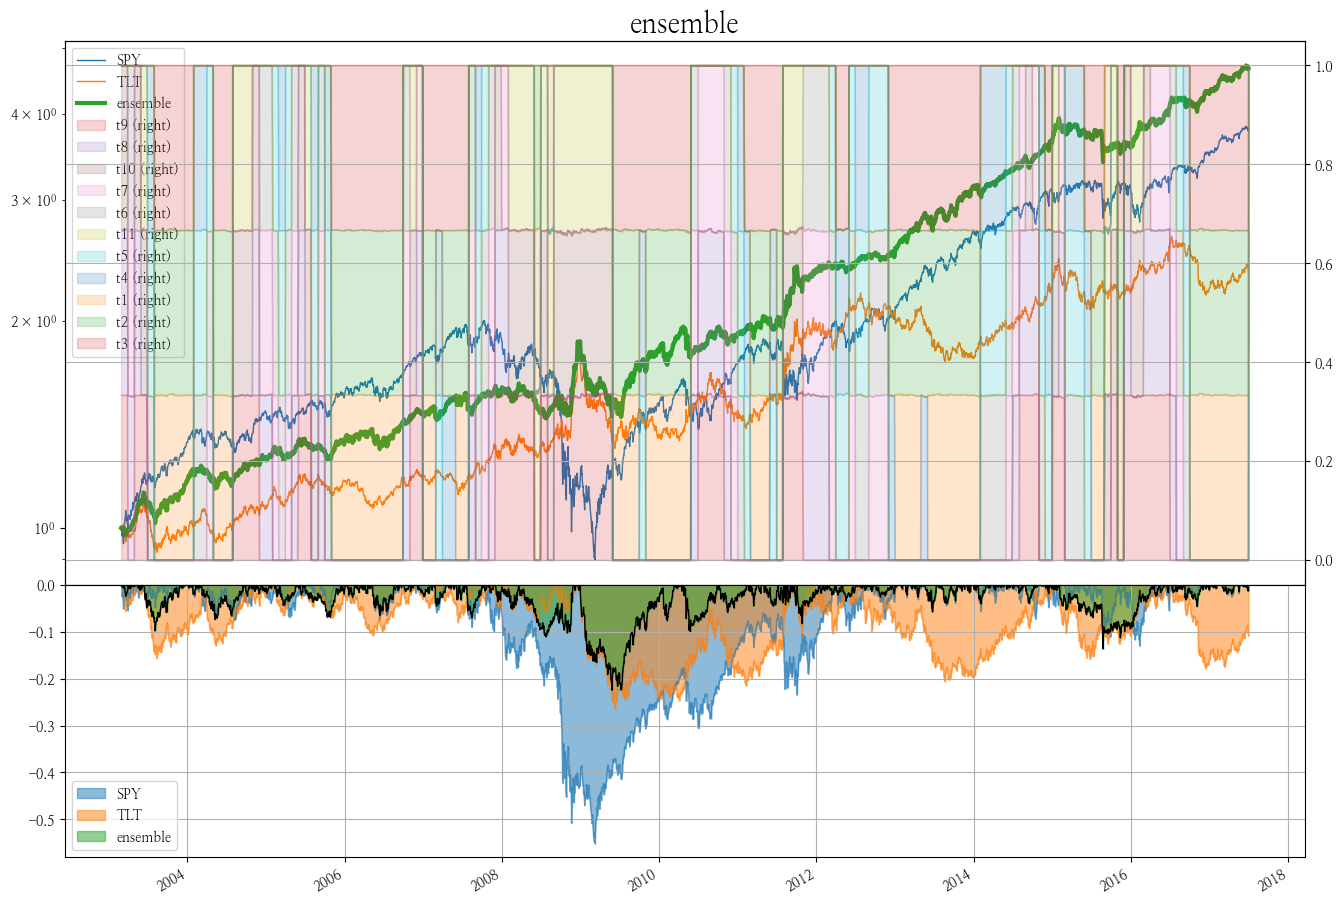

In [27]:
plot_assets(r_asset, start, e, 'ensemble')